In [18]:
import numpy as np
import torch
import sys
from utils_old import *
from matplotlib import pyplot as plt
import torch.nn as nn
import time
from numba import cuda
from tqdm import tqdm, trange
import os
import pyroc
import pandas as pd
import gc
from IPython.display import clear_output
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  
device = torch.device("cuda:0")
dtype = torch.float32
torch.manual_seed(42)
np.random.seed(42)

In [19]:

H = 500
out= 100
L = 1
class DN(torch.nn.Module):
    def __init__(self, H=300, out=100):
        super(DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, out, bias=True),
        )
    def forward(self, input):
        output = self.model(input)
        return output

class another_DN(torch.nn.Module):
    def __init__(self, H=300, out=100):
        super(another_DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, 28, bias=True),
        )
    def forward(self, input):
        output = self.model(input) + input
        return output

class Classifier(torch.nn.Module):
    def __init__(self, H=300, layers = 5):
        super(Classifier, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, 1, bias=True),
            torch.nn.Sigmoid(),
        )
        if layers == 6:
            self.model = torch.nn.Sequential(
                torch.nn.Linear(28, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, 1, bias=True),
                torch.nn.Sigmoid(),
            )
    def forward(self, input):
        output = self.model(input)
        return output

In [20]:
dataset = np.load('HIGGS.npy')
dataset_P = dataset[dataset[:,0]==0][:, 1:] # background (5829122, 28)
dataset_Q = dataset[dataset[:,0]==1][:, 1:] # signal     (5170877, 28)
del dataset

In [21]:
n_train = 1300000
path ='./Res_Net/checkpoint1300000/0/'
model = DN(300, 100).cuda()
another_model = another_DN(300, 100).cuda()
model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)

In [22]:
def generate_PQ(n_test, Samples, batch_size = 10000, If_n_large_MonteCarlo = 1000):
    '''
    Input: 
        n_test: n_test in our paper, then we generate $X^{test}$ and $Y^{test}$ used to compute MMD.
        Samples: we generate 'Samples' samples from P and Q, then compute their scores f(sample;X_test,Y_test)
    Output:
        X_test, Y_test: generate from P and Q, each with size (n_test, 28)
        P_scores, Q_scores: scores of samples from P and Q, each with size (Samples,)
        EKxx, EKyy, EKxy: expectation of K(X,X), K(Y,Y), K(X,Y), where X~P_X, Y~P_Y. Then the gamma in our paper can be computed from these three values.
    '''
    X_test = dataset_P[np.random.choice(n_train, n_test, replace=False)]
    Y_test = dataset_Q[np.random.choice(n_train, n_test, replace=False)]
    EKxx, EKyy, EKxy = compute_gamma(X_test, Y_test, model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst, MonteCarlo=If_n_large_MonteCarlo)
    batches = (Samples-1)//batch_size + 1
    P_scores = np.zeros(Samples)
    Q_scores = np.zeros(Samples)
    for i in trange(batches):
        remain = batch_size
        if i==batches-1:
            remain = Samples - batch_size*(batches-1)
        S_hand = np.concatenate((dataset_P[np.random.choice(dataset_P.shape[0], remain, replace=False)],
                    dataset_Q[np.random.choice(dataset_Q.shape[0], remain, replace=False)]), axis=0)
        S_hand = MatConvert(S_hand, device, dtype)
        PQhat_hand = compute_score_func(S_hand, X_test, Y_test, 
                    model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                    M = n_test)
        PQhat_hand = PQhat_hand.cpu().detach().numpy()
        P_scores[i*batch_size: i*batch_size+remain] = PQhat_hand[:remain]
        Q_scores[i*batch_size: i*batch_size+remain] = PQhat_hand[remain:]
    return X_test, Y_test, P_scores, Q_scores, EKxx, EKyy, EKxy


In [23]:
class PQ_data():
    '''
    Define a class to compute the p-value, the Type I/II error.
    '''
    def __init__(self, P_scores, Q_scores, EKxx, EKyy, EKxy):
        self.P_scores = P_scores
        self.Q_scores = Q_scores
        self.P_mean = np.mean(P_scores)
        self.P_std = np.std(P_scores)
        self.Q_mean = np.mean(Q_scores)
        self.Q_std = np.std(Q_scores)
        self.EKxx = EKxx
        self.EKyy = EKyy
        self.EKxy = EKxy
    def pval_T_m_in_sigma(self, pi, m, use_gaussian, MonteCarlo):
        '''
        Compute the expected significance of discovery.
        Input:
            pi: the strength of the mixture in our paper.
            m: the number of samples, i.e. the size of Z in our paper.
            use_gaussian: if use Gaussian Approximation, then use_gaussian = True, else use_gaussian = False.
            MonteCarlo: when use_gaussian = False, we use Monte Carlo to approximate the expectation.
        Output:
            p: the expected significance of discovery (in units of Gaussian sigma)
        '''
        T = pi*self.Q_mean + (1-pi)*self.P_mean
        P_scores = self.P_scores
        mean = self.P_mean
        std = self.P_std
        if m==1:
            p = np.mean(P_scores > T)
            p = -scipy.stats.norm.ppf(p)
        if use_gaussian:
            p = (T-mean)/std*np.sqrt(m)
        else:
            T_mix_MonteCarlo_list = np.zeros(MonteCarlo)
            for i in range(MonteCarlo):
                idx = np.random.choice(P_scores.shape[0], m, replace=False)
                T_mix_MonteCarlo_list[i] = np.mean(P_scores[idx])
            p = np.mean(T_mix_MonteCarlo_list > T)
            p = -scipy.stats.norm.ppf(p)
        self.p = p
        return p
    def type_1_error_H0(self, pi, m, use_gaussian, MonteCarlo):
        '''
        Compute the estimated Type I error.
        Input:
            pi: the strength of the mixture in our paper.
            m: the number of samples, i.e. the size of Z in our paper.
            use_gaussian: if use Gaussian Approximation, then use_gaussian = True, else use_gaussian = False.
            MonteCarlo: when use_gaussian = False, we use Monte Carlo to approximate the expectation.
        Output:
            type_1_error: the estimated Type I error.   
        '''
        P_scores = self.P_scores
        Q_scores = self.Q_scores
        mean = self.P_mean
        std = self.P_std
        gamma = self.EKxx*(pi/2-1) + self.EKxy*(1-pi) + self.EKyy*(pi/2)
        self.gamma = gamma
        if m==1:
            type_1_error = np.mean(P_scores > gamma)
        if use_gaussian:
            type_1_error = 1-scipy.stats.norm.cdf((gamma-mean)/std*np.sqrt(m))
        else:
            MonteCarlo_list = np.zeros(MonteCarlo)
            for i in range(MonteCarlo):
                idx = np.random.choice(P_scores.shape[0], m, replace=False)
                MonteCarlo_list[i] = np.mean(P_scores[idx])
            type_1_error = np.mean(MonteCarlo_list > gamma)
        self.type_1_error = type_1_error
        return type_1_error
    def type_2_error_H1(self, pi, m, use_gaussian, MonteCarlo):
        '''
        Compute the estimated Type II error.
        Input:
            pi: the strength of the mixture in our paper.
            m: the number of samples, i.e. the size of Z in our paper.
            use_gaussian: if use Gaussian Approximation, then use_gaussian = True, else use_gaussian = False.
            MonteCarlo: when use_gaussian = False, we use Monte Carlo to approximate the expectation.
        Output:
            type_2_error: the estimated Type II error.              
        '''
        P_scores = self.P_scores
        Q_scores = self.Q_scores
        P_mean = self.P_mean
        P_std = self.P_std
        Q_mean = self.Q_mean
        Q_std = self.Q_std
        gamma = self.EKxx*(pi/2-1) + self.EKxy*(1-pi) + self.EKyy*(pi/2)
        self.gamma = gamma
        if m==1:
            type_2_error = np.mean(Q_scores < gamma)
        if use_gaussian:
            mean = Q_mean*pi + P_mean*(1-pi)
            std = np.sqrt(pi*Q_std**2 + (1-pi)*P_std**2)
            type_2_error = scipy.stats.norm.cdf((gamma-mean)/std*np.sqrt(m))
        else:
            MonteCarlo_list = np.zeros(MonteCarlo)
            for i in range(MonteCarlo):
                Signals_idx = np.random.choice(Q_scores.shape[0], int(m*pi), replace=False)
                Backgrounds_idx = np.random.choice(P_scores.shape[0], int(m*(1-pi)), replace=False)
                MonteCarlo_list[i] = np.mean(np.concatenate((Q_scores[Signals_idx], P_scores[Backgrounds_idx])))
            type_2_error = np.mean(MonteCarlo_list < gamma)
        self.type_2_error = type_2_error
        return type_2_error

In [24]:
torch.cuda.empty_cache()
gc.collect()

4219

# Just for giving some intuition 

100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


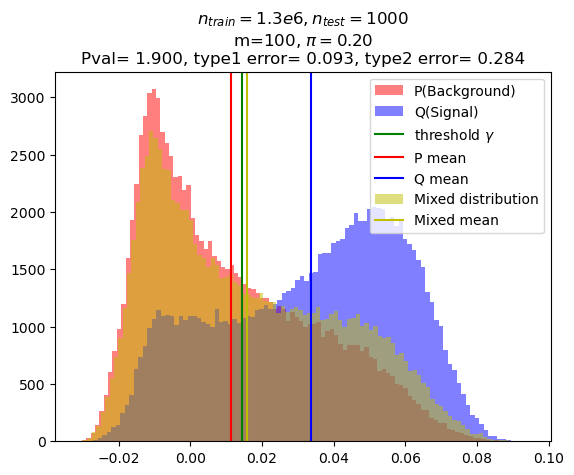

In [25]:
n_test = 20000
Samples = 100000
X_test, Y_test, P_scores, Q_scores, EKxx, EKyy, EKxy = generate_PQ(n_test, Samples=100000, batch_size=10000, If_n_large_MonteCarlo = 10)
plt.hist(P_scores, bins=100, alpha=0.5, label='P(Background)', color='r')
plt.hist(Q_scores, bins=100, alpha=0.5, label='Q(Signal)', color='b')
My_class = PQ_data(P_scores, Q_scores, EKxx, EKyy, EKxy)
m = 100
pi = 0.2
Pval = My_class.pval_T_m_in_sigma(pi, m, use_gaussian=1, MonteCarlo=0)
Type1 = My_class.type_1_error_H0(pi, m, use_gaussian=1, MonteCarlo=0)
Type2 = My_class.type_2_error_H1(pi, m, use_gaussian=1, MonteCarlo=0)
plt.axvline(My_class.gamma, color='g', label='threshold $\gamma$')
plt.axvline(My_class.P_mean, color='r', label='P mean')
plt.axvline(My_class.Q_mean, color='b', label='Q mean')
title1 = '$n_{train}=1.3e6, n_{test}=%d$'%n_test
title2 = 'm=%d, $\pi=%.2f$'%(m, pi)
title3 = 'Pval= %.3f, type1 error= %.3f, type2 error= %.3f'%(Pval, Type1, Type2)
plt.title(title1+'\n'+title2+'\n'+title3)
Mix_scores = np.concatenate((P_scores[0:int(Samples*(1-pi))], Q_scores[0:int(Samples*pi)]))
plt.hist(Mix_scores, bins=100, alpha=0.5, label='Mixed distribution', color='y')
Mix_mean = np.mean(Mix_scores)
plt.axvline(Mix_mean, color='y', label='Mixed mean')
plt.legend()

# $\pi=0.1$, use Gaussian approximation

In [26]:
pi= 0.1
# n_list is the list of all n_test to plot
n_list = np.array([2, 6, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000,])
# m_list is the list of all m to plot
m_list = np.array([1, 2, 6, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000,])

n_list = 10**np.linspace(0.5, 4.3, 40)
n_list = n_list.astype(int)
m_list = 10**np.linspace(0.5, 4.3, 40)
m_list = m_list.astype(int)

repeat_sample_n_test = 2000
Pval_mat = np.zeros((len(n_list), len(m_list),repeat_sample_n_test))
Type1_mat = np.zeros((len(n_list), len(m_list),repeat_sample_n_test))
Type2_mat = np.zeros((len(n_list), len(m_list),repeat_sample_n_test))
Use_Gaussian = 1

In [ ]:
for r in range(repeat_sample_n_test):
    for i in trange(len(n_list)):
        with torch.no_grad():
            torch.cuda.empty_cache()
            n_test = n_list[i]
            X_test, Y_test, P_scores, Q_scores, EKxx, EKyy, EKxy = generate_PQ(n_test, Samples=20000, batch_size=4000, If_n_large_MonteCarlo=10)
            My_class = PQ_data(P_scores, Q_scores, EKxx, EKyy, EKxy)
            for j in range(len(m_list)):
                m = m_list[j]
                Pval_mat[i,j,r] += My_class.pval_T_m_in_sigma(pi, m, use_gaussian=Use_Gaussian, MonteCarlo=0)
                Type1_mat[i,j,r] += My_class.type_1_error_H0(pi, m, use_gaussian=Use_Gaussian, MonteCarlo=0)
                Type2_mat[i,j,r] += My_class.type_2_error_H1(pi, m, use_gaussian=Use_Gaussian, MonteCarlo=0)
            del My_class, X_test, Y_test, P_scores, Q_scores, EKxx, EKyy, EKxy
            gc.collect()
        clear_output()   
        print(r)

In [32]:
Type1_mat  = np.mean(Type1_mat[:,:,0:r], axis=2)
Type2_mat  = np.mean(Type2_mat[:,:,0:r], axis=2)
Type12_mat = Type1_mat + Type2_mat
np.save('Type12_mat.npy', Type12_mat)

[1.41601572e-16 6.02303597e-12 1.13950872e-08 2.38005366e-06
 1.04454774e-04 1.51920741e-03 1.01096864e-02 3.86778616e-02
 1.00000000e-01 1.95908922e-01 3.15364473e-01 4.41760225e-01
 5.60804328e-01 6.64006085e-01 7.48354645e-01 8.14469651e-01
 8.64777269e-01 9.02259868e-01 9.29773627e-01 9.49757624e-01
 9.64164347e-01]


Text(0.5, 1.0, 'Type I error + II error')

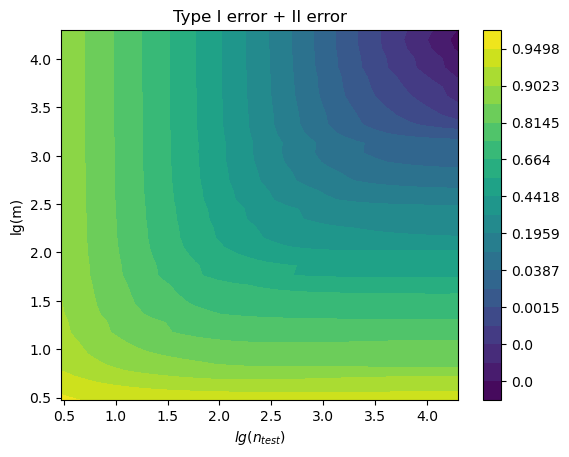

In [36]:
Type12_mat = np.load('Type12_mat.npy')
levels = 20
fig, ax = plt.subplots()
Type12_mat_log = -np.log10(-np.log10(Type12_mat))
contourf_ = ax.contourf(np.log10(n_list), np.log10(m_list), Type12_mat_log,levels=levels)
cb = fig.colorbar(contourf_)

log_log_p_list = cb.mappable.levels # np.linspace(Type12_mat_log.min()+0.00001, Type12_mat_log.max()-0.000001, levels+1)
real_p_list = 10**(-(10**(-log_log_p_list)))
# cb.set_ticks(log_log_p_list)
# # numpy to str list with 3 decimal
print(real_p_list)
real_p_list = np.around(real_p_list, decimals=4)
real_p_list = real_p_list.astype(str)
# real_p_list[0] = '1.42e-16'
# real_p_list[1] = '6.02e-12'
# real_p_list[2] = '1.14e-08'
# real_p_list[3] = '2.38e-06'
cb.set_ticks(log_log_p_list[1:-1:2])
cb.set_ticklabels(real_p_list[1:-1:2])

plt.xlabel('$lg(n_{test})$')
plt.ylabel('lg(m)')
plt.title('Type I error + II error')
# plt.xlim(1, 4)
# plt.ylim(1, 4)